In [32]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pickle
import seg_metrics.seg_metrics as sg
import json
import SimpleITK as sitk

#### compare the prediction from nnU-Net with the PET ground truth

In [33]:
DATASET_ID = 162
TEST_ID = 0

In [34]:
RAW_DIR = '/mnt/data/datasets/RNSH_HFlung/nnU-Net-processing/nnUNet_raw'
DATASET_BASE_DIR = '{}/Dataset{}_RNSH_HFlung'.format(RAW_DIR, DATASET_ID)

In [35]:
CHECKPOINT = 'best'
# CHECKPOINT = 'final'

prediction_img = nib.load('/mnt/data/datasets/RNSH_HFlung/nnU-Net-processing/nnUNet_predictions/Dataset{}_RNSH_HFlung/{}/RNSH_HFlung_{:04d}.nii.gz'.format(DATASET_ID, CHECKPOINT, TEST_ID)).get_fdata()
prediction_img.shape

(320, 320, 300)

In [36]:
label_img = nib.load('{}/labelsTs/RNSH_HFlung_{:04d}.nii.gz'.format(DATASET_BASE_DIR, TEST_ID)).get_fdata()
label_img.shape

(320, 320, 300)

In [37]:
DISPLAY_IDX = 100

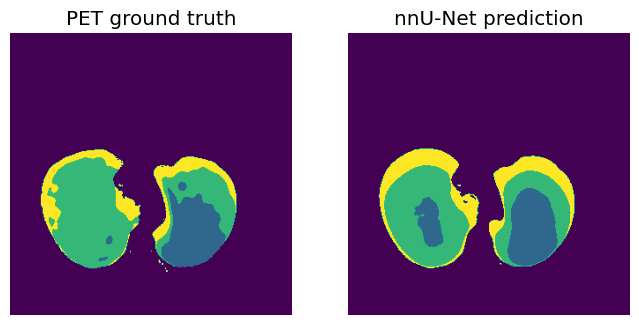

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.imshow(label_img[:,:,DISPLAY_IDX].T)
ax1.set_title('PET ground truth')
ax1.set_axis_off()

ax2.imshow(prediction_img[:,:,DISPLAY_IDX].T)
ax2.set_title('nnU-Net prediction')
ax2.set_axis_off()

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [40]:
nnunet_cm = confusion_matrix(label_img.ravel(), prediction_img.ravel())
nnunet_cm = nnunet_cm.astype('float') / nnunet_cm.sum(axis=1)[:, np.newaxis]

In [41]:
plt.rcParams['font.size'] = 12

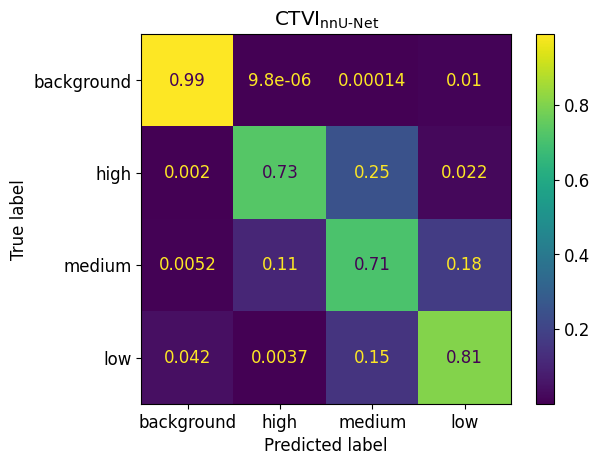

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix=nnunet_cm, display_labels=['background','high','medium','low'])
disp.plot()
plt.title(r'CTVI$_\text{nnU-Net}$')
plt.show()

In [43]:
nnunet_dsc = {}
print('nnU-Net and PET DSC')
for idx,label in enumerate(['high','medium','low']):
    k = idx+1
    dice = np.sum(prediction_img[label_img==k]==k)*2.0 / (np.sum(prediction_img[prediction_img==k]==k) + np.sum(label_img[label_img==k]==k))
    nnunet_dsc[label] = dice
    print('{}: {}'.format(label, round(dice,2)))

nnU-Net and PET DSC
high: 0.78
medium: 0.71
low: 0.71


In [44]:
labels = [0, 1, 2, 3]

metrics = sg.write_metrics(labels=labels,
                  gdth_img=label_img,
                  pred_img=prediction_img,
                  csv_file=None,
                  metrics=['vs','hd','hd95'])

In [45]:
nnunet_hd95 = metrics[0]['hd95']
print('Hausdorff distance 95% percentile')
print('high: {}'.format(round(nnunet_hd95[1])))
print('medium: {}'.format(round(nnunet_hd95[2])))
print('low: {}'.format(round(nnunet_hd95[3])))

Hausdorff distance 95% percentile
high: 19
medium: 11
low: 9


#### compare with DIR approach

In [46]:
# get the patient ID for this hold-out test patient
MAPPING_FILE = '{}/patient-mapping-Dataset{}_RNSH_HFlung.json'.format(RAW_DIR, DATASET_ID)

with open(MAPPING_FILE, 'r') as fp:
    patient_map_d = json.load(fp)

In [47]:
patient_id = int(patient_map_d['test'][TEST_ID][0].split('/')[-1].split('.')[0].split('Patient')[1])
patient_id

14

In [48]:
PREPROCESSED_BASE_DIR = '/mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch'
PREPROCESSED_MHA_DIR = '{}/mha/Patient{:02d}'.format(PREPROCESSED_BASE_DIR, patient_id)

In [49]:
ctvi_jac_label_arr = sitk.GetArrayFromImage(sitk.ReadImage('{}/ctvi-jac-label.mha'.format(PREPROCESSED_MHA_DIR)))
ctvi_jac_label_arr.shape

(300, 320, 320)

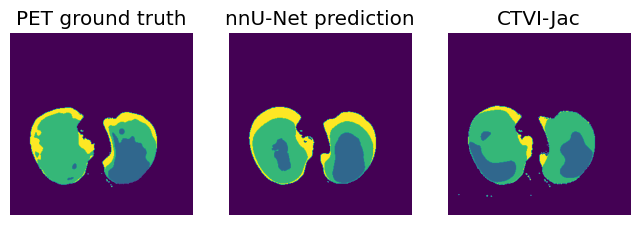

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,4))

ax1.imshow(label_img[:,:,DISPLAY_IDX].T)
ax1.set_title('PET ground truth')
ax1.set_axis_off()

ax2.imshow(prediction_img[:,:,DISPLAY_IDX].T)
ax2.set_title('nnU-Net prediction')
ax2.set_axis_off()

ax3.imshow(ctvi_jac_label_arr[DISPLAY_IDX])
ax3.set_title('CTVI-Jac')
ax3.set_axis_off()

In [51]:
ctvi_jac_label_arr.shape, label_img.shape

((300, 320, 320), (320, 320, 300))

In [52]:
ctvi_jac_label_arr = np.transpose(ctvi_jac_label_arr, axes=(2, 1, 0))

In [53]:
ctvi_jac_cm = confusion_matrix(label_img.ravel(), ctvi_jac_label_arr.ravel())
ctvi_jac_cm = ctvi_jac_cm.astype('float') / ctvi_jac_cm.sum(axis=1)[:, np.newaxis]

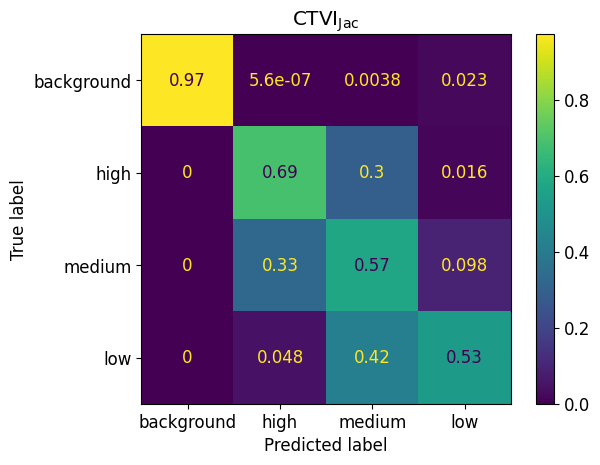

In [54]:
disp = ConfusionMatrixDisplay(confusion_matrix=ctvi_jac_cm, display_labels=['background','high','medium','low'])
disp.plot()
plt.title(r'CTVI$_\text{Jac}$')
plt.show()

In [55]:
ctvi_jac_dsc = {}
print('CTVI-Jac and PET DSC')
for idx,label in enumerate(['high','medium','low']):
    k = idx+1
    dice = np.sum(ctvi_jac_label_arr[label_img==k]==k)*2.0 / (np.sum(ctvi_jac_label_arr[ctvi_jac_label_arr==k]==k) + np.sum(label_img[label_img==k]==k))
    ctvi_jac_dsc[label] = dice
    print('{}: {}'.format(label, round(dice,2)))

CTVI-Jac and PET DSC
high: 0.63
medium: 0.53
low: 0.49


In [56]:
labels = [0, 1, 2, 3]

metrics = sg.write_metrics(labels=labels,
                  gdth_img=label_img,
                  pred_img=prediction_img,
                  csv_file=None,
                  metrics=['vs','hd','hd95'])

In [57]:
ctvi_jac_hd95 = metrics[0]['hd95']
print('Hausdorff distance 95% percentile')
print('high: {}'.format(round(ctvi_jac_hd95[1])))
print('medium: {}'.format(round(ctvi_jac_hd95[2])))
print('low: {}'.format(round(ctvi_jac_hd95[3])))

Hausdorff distance 95% percentile
high: 19
medium: 11
low: 9


#### store the metrics by dataset and test patient ID

In [58]:
ANALYSIS_DIR = '/home/daryl/analysis'
ANALYSIS_FILE = '{}/nnunet-metrics-final.pkl'.format(ANALYSIS_DIR)

In [59]:
if not os.path.exists(ANALYSIS_DIR):
    os.makedirs(ANALYSIS_DIR)

nnunet_d = {
    'confusion_matrix':nnunet_cm, 
    'DSC_low':np.round(nnunet_dsc['low'],2), 'DSC_medium':np.round(nnunet_dsc['medium'],2), 'DSC_high':np.round(nnunet_dsc['high'],2),
    'HD95_low':np.round(nnunet_hd95[3]), 'HD95_medium':np.round(nnunet_hd95[2]), 'HD95_high':np.round(nnunet_hd95[1]),
}
ctvi_jac_d = {
    'confusion_matrix':ctvi_jac_cm, 
    'DSC_low':np.round(ctvi_jac_dsc['low'],2), 'DSC_medium':np.round(ctvi_jac_dsc['medium'],2), 'DSC_high':np.round(ctvi_jac_dsc['high'],2),
    'HD95_low':np.round(ctvi_jac_hd95[3]), 'HD95_medium':np.round(ctvi_jac_hd95[2]), 'HD95_high':np.round(ctvi_jac_hd95[1]),
}
patient_d = {
    'dataset_id':DATASET_ID, 
    'test_id':TEST_ID, 
    'nnunet_d':nnunet_d,
    'ctvi_jac_d':ctvi_jac_d
}

if os.path.isfile(ANALYSIS_FILE):
    with open(ANALYSIS_FILE, 'rb') as f:
        analysis_d = pickle.load(f)
else:
    analysis_d = {}

analysis_d[patient_id] = patient_d

with open(ANALYSIS_FILE, 'wb') as f:
        pickle.dump(analysis_d, f)

In [60]:
print('{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}'.format('patient ID', 'dataset', 'test ID', '', '', '', 'nnU-Net', '', '', '', 'CTVI-Jac'))
print('{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}{: >10}'.format('', '', '', 'high', 'medium', 'low', 'mean', 'high', 'medium', 'low', 'mean'))
print('-'*110)

ctvi_jac_DSC_d = {'high':[],'medium':[],'low':[],'mean':[]}
nnunet_DSC_d = {'high':[],'medium':[],'low':[],'mean':[]}
for key,value in analysis_d.items():
    ctvi_jac_d = value['ctvi_jac_d']
    ctvi_jac_DSC_mean = np.mean([ctvi_jac_d['DSC_high'],ctvi_jac_d['DSC_medium'],ctvi_jac_d['DSC_low']])
    ctvi_jac_DSC_d['high'].append(ctvi_jac_d['DSC_high'])
    ctvi_jac_DSC_d['medium'].append(ctvi_jac_d['DSC_medium'])
    ctvi_jac_DSC_d['low'].append(ctvi_jac_d['DSC_low'])
    ctvi_jac_DSC_d['mean'].append(ctvi_jac_DSC_mean)
    
    nnunet_d = value['nnunet_d']
    nnunet_mean = np.mean([nnunet_d['DSC_high'],nnunet_d['DSC_medium'],nnunet_d['DSC_low']])
    nnunet_DSC_d['high'].append(nnunet_d['DSC_high'])
    nnunet_DSC_d['medium'].append(nnunet_d['DSC_medium'])
    nnunet_DSC_d['low'].append(nnunet_d['DSC_low'])
    nnunet_DSC_d['mean'].append(nnunet_mean)
    
    print('{: >10}{: >10}{: >10}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}'.format(key, value['dataset_id'], value['test_id'], 
                                                                                 nnunet_d['DSC_high'], nnunet_d['DSC_medium'], nnunet_d['DSC_low'], nnunet_mean,
                                                                                 ctvi_jac_d['DSC_high'], ctvi_jac_d['DSC_medium'], ctvi_jac_d['DSC_low'], ctvi_jac_DSC_mean
                                                                                )
         )
print('-'*110)
print('{: >10}{: >10}{: >10}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}{: >10.2f}'.format('means', '', '', 
                                                                             np.mean(nnunet_DSC_d['high']), np.mean(nnunet_DSC_d['medium']), np.mean(nnunet_DSC_d['low']), np.mean(nnunet_DSC_d['mean']),
                                                                             np.mean(ctvi_jac_DSC_d['high']), np.mean(ctvi_jac_DSC_d['medium']), np.mean(ctvi_jac_DSC_d['low']), np.mean(ctvi_jac_DSC_d['mean'])
                                                                            )
     )

patient ID   dataset   test ID                                 nnU-Net                                CTVI-Jac
                                    high    medium       low      mean      high    medium       low      mean
--------------------------------------------------------------------------------------------------------------
         9       160         1      0.72      0.64      0.56      0.64      0.65      0.57      0.53      0.58
         4       160         0      0.71      0.62      0.59      0.64      0.67      0.52      0.53      0.57
        11       161         0      0.71      0.61      0.63      0.65      0.69      0.60      0.55      0.61
         2       161         1      0.55      0.56      0.57      0.56      0.37      0.43      0.40      0.40
        14       162         0      0.78      0.71      0.71      0.73      0.63      0.53      0.49      0.55
         7       162         1      0.62      0.43      0.33      0.46      0.52      0.32      0.15      0.33
-

In [61]:
boxplot_nnunet = []
boxplot_nnunet.append(nnunet_DSC_d['high'])
boxplot_nnunet.append(nnunet_DSC_d['medium'])
boxplot_nnunet.append(nnunet_DSC_d['low'])

boxplot_dir = []
boxplot_dir.append(ctvi_jac_DSC_d['high'])
boxplot_dir.append(ctvi_jac_DSC_d['medium'])
boxplot_dir.append(ctvi_jac_DSC_d['low'])

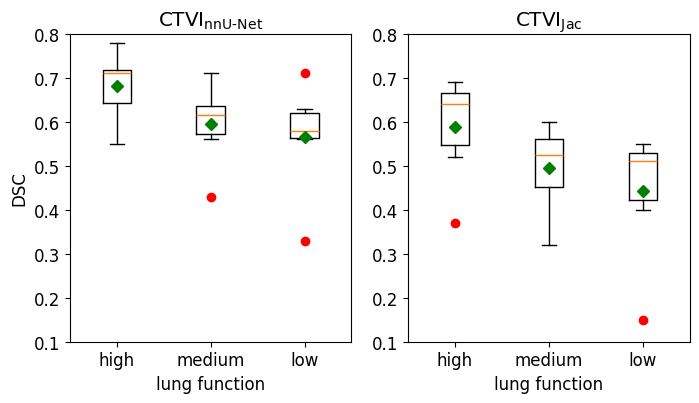

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
plt.margins(0.06)

red_circle = dict(markerfacecolor='red', markeredgecolor='red', marker='o')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')

_ = ax1.boxplot(boxplot_nnunet, showfliers=True, showmeans=True, meanprops=mean_shape, flierprops=red_circle)
_ = ax2.boxplot(boxplot_dir, showfliers=True, showmeans=True, meanprops=mean_shape, flierprops=red_circle)

ax1.set_title(r'CTVI$_\text{nnU-Net}$')
ax2.set_title(r'CTVI$_\text{Jac}$')
ax1.set_xticklabels(['high', 'medium', 'low'])
ax2.set_xticklabels(['high', 'medium', 'low'])
ax1.set_xlabel('lung function')
ax2.set_xlabel('lung function')
ax1.set_ylabel('DSC')
ax1.set_ylim([0.1, 0.8])
ax2.set_ylim([0.1, 0.8])
plt.show()